# Libraries

In [1]:
import sys
import os

import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import torch

from pathlib import Path

In [2]:
# Set the font family for math symbols
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
home_path = Path.home()
print(home_path)

current_dir_path = Path.cwd()
print(current_dir_path)

askap     = home_path / 'ANU' / 'ASKAP'
data_path = askap / 'data'

ml_data_path = data_path / 'ML'
ppv_data_path = ml_data_path / 'ppv'
seta_data_path = ml_data_path / 'seta22'

train_data_path = ml_data_path / 'train'


print(train_data_path)
print(ppv_data_path)

# Fcn

In [ ]:
def split_into_chunks(arr, chunk_size):
    return np.array([arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)])

def split_into_chunks(arr, chunk_size):
    return [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

# GPU or CPU

In [7]:
# GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


In [8]:
torch.cuda.device_count()

0

# CNN (1split)

In [9]:
exp0_data_path  = train_data_path / 'cnn'
checkpoint_path = exp0_data_path / 'checkpoint'
training_process_path = exp0_data_path / 'cnn256_231113_n7_1split'

In [ ]:
pe_list  = ['original_vector',  'index_concate',  'index_add',  'sin_concate',  'sin_add', 'poly_concate']
pev_list = ['Original', 'Concat Index', 'Add Index', 'Concat Sinusoidal', 'Add Sinusoidal', 'Concat Polynomial']
npe        = len(pe_list)

prex   = 'cnn_'
suffix = '_c256'

file_list  = [training_process_path / (prex + x + suffix + '.csv') for x in pe_list]
file_list

In [11]:
valid_mean_mse_arr = np.zeros(npe)
valid_std_mse_arr = np.zeros(npe)

test_mean_mse_arr = np.zeros(npe)
test_std_mse_arr = np.zeros(npe)

valid_mean_mse_arr_list = []
test_mean_mse_arr_list  = []

for (i, csvfile) in enumerate(file_list):
  df = pd.read_csv(csvfile)

  valid_mse_values = np.sqrt(df.valid_err.values)
  test_mse_values  = np.sqrt(df.test_err.values)

  valid_mean_mse_arr_list.append(valid_mse_values)
  test_mean_mse_arr_list.append(test_mse_values)

  valid_mean_mse = np.median(valid_mse_values)
  valid_std_mse  = valid_mse_values.std()

  test_mean_mse  = np.median(test_mse_values)
  test_std_mse   = test_mse_values.std()

  valid_mean_mse_arr[i] = valid_mean_mse
  valid_std_mse_arr[i] = valid_std_mse

  test_mean_mse_arr[i] = test_mean_mse
  test_std_mse_arr[i] = test_std_mse

In [13]:
for m,s,xi in zip(valid_mean_mse_arr, valid_std_mse_arr, pev_list):
  print(f"Valid MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Valid MSE: Mean=0.085850, std=0.001433  for Original
Valid MSE: Mean=0.084992, std=0.000906  for Concat Index
Valid MSE: Mean=0.085240, std=0.000981  for Add Index
Valid MSE: Mean=0.080908, std=0.002588  for Concat Sinusoidal
Valid MSE: Mean=0.083015, std=0.000554  for Add Sinusoidal
Valid MSE: Mean=0.080896, std=0.000618  for Concat Polynomial


In [14]:
for m,s,xi in zip(test_mean_mse_arr, test_std_mse_arr, pev_list):
  print(f"Test MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Test MSE: Mean=0.086760, std=0.001324  for Original
Test MSE: Mean=0.085176, std=0.000700  for Concat Index
Test MSE: Mean=0.085708, std=0.001175  for Add Index
Test MSE: Mean=0.084243, std=0.000893  for Concat Sinusoidal
Test MSE: Mean=0.082421, std=0.000966  for Add Sinusoidal
Test MSE: Mean=0.084282, std=0.000954  for Concat Polynomial


In [ ]:
file_list1  = [training_process_path / (prex + x + '_process' + suffix + '.csv') for x in pe_list]
file_list1

In [19]:
k = 2
pev = pev_list[k]
process_df = pd.read_csv(training_process_path / file_list1[k])
print(process_df.shape)
process_df.head()

(600, 4)


,epoch,train_err,valid_err,test_err
0,0,0.035087,0.025555,0.021251
1,1,0.024675,0.019450,0.016604
2,2,0.021841,0.017667,0.015391
3,3,0.019186,0.224177,0.225951
4,4,0.017824,0.016555,0.014245


In [20]:
process_train_err    = np.sqrt(process_df['train_err'].values)
process_validate_err = np.sqrt(process_df['valid_err'].values)
process_test_err     = np.sqrt(process_df['test_err'].values)
epochs               = process_df['epoch'].values

In [22]:
nepochs = epochs.max() + 1
nepochs

60

In [23]:
epoch_chunks = split_into_chunks(epochs, nepochs)
process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

In [26]:
rp, p_value = spearmanr(process_train_err, process_validate_err)

print(f"Pearson Correlation Coefficient: {rp}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.906195072764091
P-value: 1.0508332606396766e-225


In [29]:
npe

6

In [30]:
process_train_rmse_mean = np.zeros((10, npe))
process_valid_rmse_mean = np.zeros((10, npe))
process_test_rmse_mean  = np.zeros((10, npe))

mean_train_mse_cnn = np.zeros(nepochs)
mean_valid_mse_cnn = np.zeros(nepochs)
mean_test_mse_cnn  = np.zeros(nepochs)

# Loop through your scatter plot data and create subplots
for i, (xfile_list, pev) in enumerate(zip(file_list1, pev_list)):
    process_df = pd.read_csv(training_process_path / xfile_list)

    process_train_err    = np.sqrt(process_df['train_err'].values)
    process_validate_err = np.sqrt(process_df['valid_err'].values)
    process_test_err     = np.sqrt(process_df['test_err'].values)
    epochs               = process_df['epoch'].values

    epoch_chunks = split_into_chunks(epochs, nepochs)
    process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
    process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
    process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

    process_train_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_train_err_chunks])
    process_valid_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_validate_err_chunks])
    process_test_rmse_mean[:,i]  = np.asarray([np.median(x) for x in process_test_err_chunks])

    mean_process_train_err    = process_train_err_chunks.mean(axis=0)
    mean_process_validate_err = process_validate_err_chunks.mean(axis=0)
    mean_process_test_err     = process_test_err_chunks.mean(axis=0)

    mean_train_mse_cnn += mean_process_train_err
    mean_valid_mse_cnn += mean_process_validate_err
    mean_test_mse_cnn += mean_process_test_err
# End - for
mean_train_mse_cnn = mean_train_mse_cnn / npe
mean_valid_mse_cnn = mean_valid_mse_cnn / npe
mean_test_mse_cnn  = mean_test_mse_cnn / npe

# CNN (split)

In [34]:
exp0_data_path  = train_data_path / 'cnn'
checkpoint_path = exp0_data_path / 'checkpoint'
training_process_path = exp0_data_path / 'cnn256_split'

In [ ]:
pe_list  = ['original_vector',  'index_concate',  'index_add',  'sin_concate',  'sin_add', 'poly_concate']
pev_list = ['Original', 'Concat Index', 'Add Index', 'Concat Sinusoidal', 'Add Sinusoidal', 'Concat Polynomial']
npe        = len(pe_list)

prex = 'cnn_'
suffix = '_c256'

file_list  = [training_process_path / (prex + x + suffix + '.csv') for x in pe_list]
file_list

In [36]:
valid_mean_mse_arr = np.zeros(npe)
valid_std_mse_arr = np.zeros(npe)

test_mean_mse_arr = np.zeros(npe)
test_std_mse_arr = np.zeros(npe)

valid_mean_mse_arr_list = []
test_mean_mse_arr_list  = []

for (i, csvfile) in enumerate(file_list):
  df = pd.read_csv(csvfile)

  valid_mse_values = np.sqrt(df.valid_err.values)
  test_mse_values  = np.sqrt(df.test_err.values)

  valid_mean_mse_arr_list.append(valid_mse_values)
  test_mean_mse_arr_list.append(test_mse_values)

  valid_mean_mse = np.median(valid_mse_values)
  valid_std_mse  = valid_mse_values.std()

  test_mean_mse  = np.median(test_mse_values)
  test_std_mse   = test_mse_values.std()

  valid_mean_mse_arr[i] = valid_mean_mse
  valid_std_mse_arr[i] = valid_std_mse

  test_mean_mse_arr[i] = test_mean_mse
  test_std_mse_arr[i] = test_std_mse

In [38]:
for m,s,xi in zip(valid_mean_mse_arr, valid_std_mse_arr, pev_list):
  print(f"Valid MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Valid MSE: Mean=0.085974, std=0.001200  for Original
Valid MSE: Mean=0.083683, std=0.001812  for Concat Index
Valid MSE: Mean=0.084590, std=0.001490  for Add Index
Valid MSE: Mean=0.084719, std=0.002194  for Concat Sinusoidal
Valid MSE: Mean=0.084659, std=0.001483  for Add Sinusoidal
Valid MSE: Mean=0.082377, std=0.001407  for Concat Polynomial


In [39]:
for m,s,xi in zip(test_mean_mse_arr, test_std_mse_arr, pev_list):
  print(f"Test MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Test MSE: Mean=0.084448, std=0.001807  for Original
Test MSE: Mean=0.086277, std=0.002814  for Concat Index
Test MSE: Mean=0.084537, std=0.001075  for Add Index
Test MSE: Mean=0.086039, std=0.001705  for Concat Sinusoidal
Test MSE: Mean=0.085341, std=0.001274  for Add Sinusoidal
Test MSE: Mean=0.081454, std=0.001393  for Concat Polynomial


In [42]:
file_list  = [training_process_path / (prex + x + '_process' + suffix + '.csv') for x in pe_list]
file_list

[PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/cnn/cnn256_split/cnn_original_vector_process_c256.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/cnn/cnn256_split/cnn_index_concate_process_c256.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/cnn/cnn256_split/cnn_index_add_process_c256.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/cnn/cnn256_split/cnn_sin_concate_process_c256.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/cnn/cnn256_split/cnn_sin_add_process_c256.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/cnn/cnn256_split/cnn_poly_concate_process_c256.csv')]

In [43]:
k = 2
pev = pev_list[k]
process_df = pd.read_csv(training_process_path / file_list[k])
print(process_df.shape)
process_df.head()

(600, 4)


,epoch,train_err,valid_err,test_err
0,0,0.034257,0.025378,0.022844
1,1,0.024453,0.025585,0.023395
2,2,0.021241,0.034969,0.032608
3,3,0.018141,0.017360,0.015682
4,4,0.016446,0.014906,0.013666


In [44]:
process_train_err    = np.sqrt(process_df['train_err'].values)
process_validate_err = np.sqrt(process_df['valid_err'].values)
process_test_err     = np.sqrt(process_df['test_err'].values)
epochs               = process_df['epoch'].values

In [46]:
nepochs = epochs.max() + 1
nepochs

60

In [47]:
epoch_chunks = split_into_chunks(epochs, nepochs)
process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

In [49]:
rp, p_value = spearmanr(process_train_err, process_validate_err)

print(f"Pearson Correlation Coefficient: {rp}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.8899447498465273
P-value: 4.610597148020544e-206


In [52]:
npe

6

In [53]:
process_train_rmse_mean = np.zeros((10, npe))
process_valid_rmse_mean = np.zeros((10, npe))
process_test_rmse_mean  = np.zeros((10, npe))

# Loop through your scatter plot data and create subplots
for i, (xfile_list, pev) in enumerate(zip(file_list, pev_list)):
    process_df = pd.read_csv(training_process_path / xfile_list)

    process_train_err    = np.sqrt(process_df['train_err'].values)
    process_validate_err = np.sqrt(process_df['valid_err'].values)
    process_test_err     = np.sqrt(process_df['test_err'].values)
    epochs               = process_df['epoch'].values

    epoch_chunks = split_into_chunks(epochs, nepochs)
    process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
    process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
    process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

    process_train_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_train_err_chunks])
    process_valid_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_validate_err_chunks])
    process_test_rmse_mean[:,i]  = np.asarray([np.median(x) for x in process_test_err_chunks])

# Training/Validation correlations (1split, split)

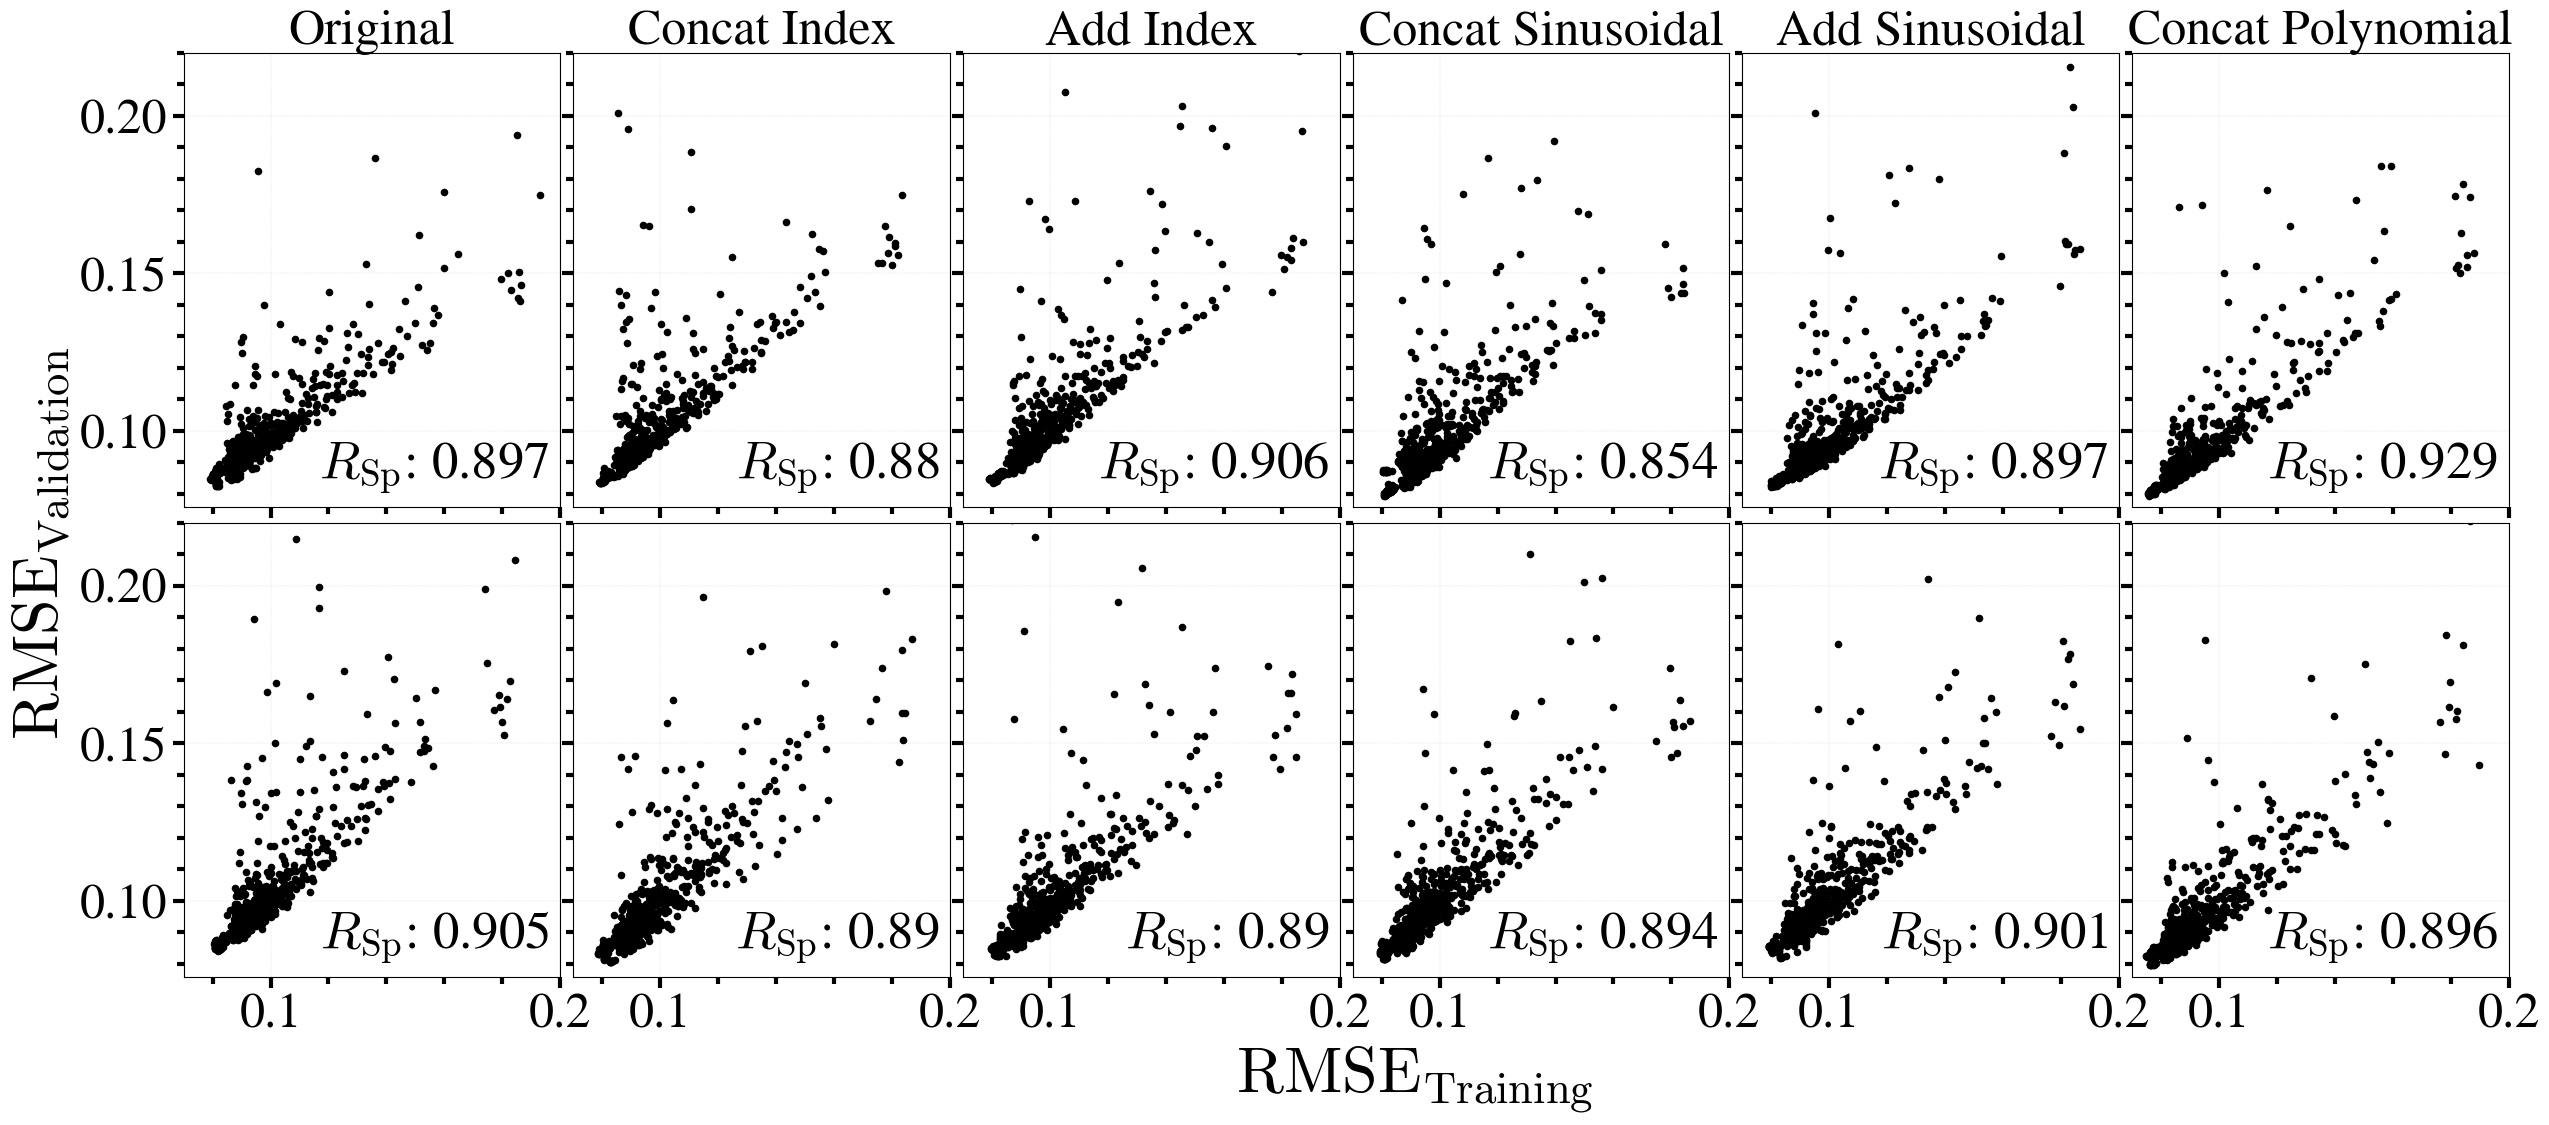

In [64]:
# Create subplots
fig, axes = plt.subplots(2, 6, figsize=(30, 12), sharex=True, sharey=True)

axes = axes.flatten()

# Loop through your scatter plot data and create subplots
for i, (xfile_list1, pev) in enumerate(zip(file_list1, pev_list)):

    # 1split
    process_df = pd.read_csv(training_process_path / xfile_list1)

    process_train_err    = np.sqrt(process_df.train_err.values)
    process_validate_err = np.sqrt(process_df.valid_err.values)
    process_test_err     = np.sqrt(process_df.test_err.values)
    epochs               = process_df.epoch.values

    rp, p_value = spearmanr(process_train_err, process_validate_err)

    ax = axes[i]
    sct1 = ax.scatter(process_train_err, process_validate_err,
                    zorder=2, s=20,
                    marker='o', vmin=0., vmax=37., c='k',
                    label='')


    

    ploti, = ax.plot([], [], 'ko', label=r'$R_\mathrm{Sp}$: ' + f'{round(rp, 3)}')
    ploti.set_visible(True)

    ax.set_title(pev, fontsize=36)
    xlabel = ''
    ylabel = r'$\mathrm{RMSE_{Validation}}$' if (i == 0)  else ''
    ax.set_ylabel(ylabel, fontsize=46, fontweight='bold')
    ax.yaxis.set_label_coords(-0.3, -0.08)

    ax.set_xlim(0.07, 0.2)
    ax.set_ylim(0.076, 0.22)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=36, pad=4)
    ax.tick_params(axis='y', labelsize=36)
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=5)

    ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
    leg = ax.legend(loc='lower right', fancybox=False, framealpha=0., labelcolor='k', fontsize=38, handletextpad=-2.0, borderaxespad=-0.2)
    [item.set_visible(False) for item in leg.legendHandles]





# Loop through your scatter plot data and create subplots
for i, (xfile_list, pev) in enumerate(zip(file_list, pev_list)):
    # Split
    proc_df = pd.read_csv(xfile_list)

    proc_train_err    = np.sqrt(proc_df.train_err.values)
    proc_validate_err = np.sqrt(proc_df.valid_err.values)
    proc_test_err     = np.sqrt(proc_df.test_err.values)
    epochs            = proc_df.epoch.values

    rp2, p_value2 = spearmanr(proc_train_err, proc_validate_err)

    ax = axes[i+6]
    sct1 = ax.scatter(proc_train_err, proc_validate_err,
                    zorder=2, s=20,
                    marker='o', vmin=0., vmax=37., c='k',
                    label='')

    ploti, = ax.plot([], [], 'ko', label=r'$R_\mathrm{Sp}$: ' + f'{round(rp2, 3)}')
    ploti.set_visible(True)

    xlabel = r'$\mathrm{RMSE_{Training}}$' if (i==2) else ''
    ylabel = r''
    ax.set_xlabel(xlabel, fontsize=46, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=0, fontweight='normal')
    ax.xaxis.set_label_coords(1.2, -0.15)

    ax.set_xlim(0.07, 0.2)
    ax.set_ylim(0.076, 0.22)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=36, pad=4)
    ax.tick_params(axis='y', labelsize=36)
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=5)

    ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
    leg = ax.legend(loc='lower right', fancybox=False, framealpha=0., labelcolor='k', fontsize=38, handletextpad=-2.0, borderaxespad=-0.2)
    [item.set_visible(False) for item in leg.legendHandles]
# End - for

plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.035,
                    hspace=0.035
                    )


# Adjust layout
# plt.tight_layout()
plt.show()